### HW lesson 4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


#### Задание 2
Заменим названия полей: conversion на target, offer на treatment

In [3]:
df.rename(columns={'conversion':'target'}, inplace=True)
df.rename(columns={'offer':'treatment'}, inplace=True)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


В поле treatment заменим значения на бинарные. "Buy One Get One" и "Discount" на 1, "No Offer" на 0 (Было какое-то предложение или нет) и поменяем тип данных на float

In [4]:
df.loc[(df['treatment'] == 'Buy One Get One'), 'treatment'] = float(1)
df.loc[(df['treatment'] == 'Discount'), 'treatment'] = float(1)
df.loc[(df['treatment'] == 'No Offer'), 'treatment'] = float(0)

df['treatment'] = df['treatment'].astype(float)

df['treatment'].value_counts()

1.0    42694
0.0    21306
Name: treatment, dtype: int64

#### Задание 3, 4
 Обработка признаков и разбиение данных на тренировочную и тестовую выборки

In [5]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment        float64
target             int64
dtype: object

Проверим наличие пропусков в признаках

In [6]:
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

Обработаем признак "zip_code", сделаем замену строковых значений на числовые

In [7]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [8]:
df.loc[(df['zip_code'] == 'Urban'), 'zip_code'] = int(0) # Жители города - цифра 0
df.loc[(df['zip_code'] == 'Surburban'), 'zip_code'] = int(1) # Жители пригорода - цифра 1
df.loc[(df['zip_code'] == 'Rural'), 'zip_code'] = int(1) # Сельские жители - цифра 1

df['zip_code'] = df['zip_code'].astype(float)

df['zip_code'].value_counts()

1.0    38339
0.0    25661
Name: zip_code, dtype: int64

Обработаем признак "channel", сделаем замену строковых значений на числовые

In [9]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [10]:
df.loc[(df['channel'] == 'Web'), 'channel'] = int(0) # Канал связи web - цифра 0
df.loc[(df['channel'] == 'Phone'), 'channel'] = int(1) # Канал связи телефон - цифра 1
df.loc[(df['channel'] == 'Multichannel')] = int(1) # Разный канал связи - цифра 1

df['channel'] = df['channel'].astype(float)

df['channel'].value_counts()

1.0    35783
0.0    28217
Name: channel, dtype: int64

Создадим DataFrame с признаками и целевой переменной

In [11]:
columns = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel','treatment', 'target']
df_new = df[columns]

X = df_new.drop(columns=['target'])
y = df_new['target']

In [12]:
indices_train = df_new.index
indices_test = df_new.index
indices_learn, indices_valid = train_test_split(df_new.index, test_size=0.3, random_state=1)

In [13]:
X_train = df_new.loc[indices_learn, :]
y_train = df_new.loc[indices_learn, 'target']
treat_train = df_new.loc[indices_learn, 'treatment']

X_val = df_new.loc[indices_valid, :]
y_val = df_new.loc[indices_valid, 'target']
treat_val =  df_new.loc[indices_valid, 'treatment']

X_train_full = df_new.loc[indices_train, :]
y_train_full = df_new.loc[:, 'target']
treat_train_full = df_new.loc[:, 'treatment']

X_test = df_new.loc[indices_test, :]

models_results = {
    'approach': [],
    'uplift@30%': []
}

#### Задание 5
uplift-моделирование

Подход с одной моделью

uplift@30%: 0.2034


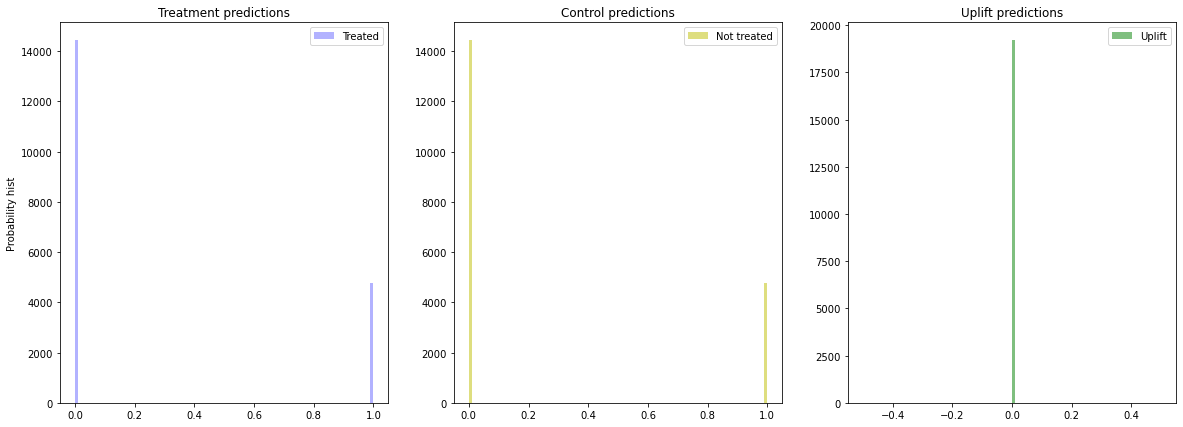

In [14]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Проверим важность признаков

In [15]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,target,98.295190
1,recency,0.826220
2,history,0.602235
3,is_referral,0.124454
4,zip_code,0.078636
5,used_discount,0.040500
6,used_bogo,0.028422
7,channel,0.004343
8,treatment,0.000000


Трансформация классов

In [16]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

Две независимые модели

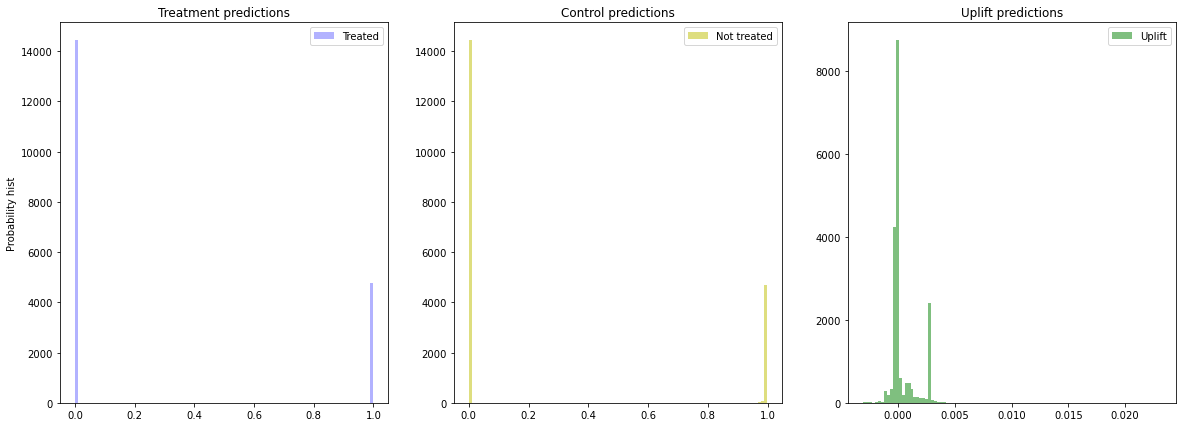

In [17]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [18]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,1.000000
2,TwoModels,0.662587
0,SoloModel,0.203380
